# Linear Classifier - Softmax

In [4]:
# All necessary imports at the beginning
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_mldata       
from sklearn.preprocessing import OneHotEncoder

## Load, explore and prepare dataset

The MNIST dataset is a classic Machine Learning dataset you can get it and more information about it from the website of [Yann Lecun](http://yann.lecun.com/exdb/mnist/). MNIST contains handwrittin digits and is split into a tranings set of 60000 examples and a test set of 10000 examples. You can use the module ```sklearn``` to load the MNIST dataset in a convenient way. 
easy load, mldata.org, orginal mnist, mnist link and description

In [5]:
mnist = fetch_mldata('MNIST original') #load MNIST
X, y = mnist["data"], mnist["target"] #separate images and labels

# shape of MNIST data
print('digits', X.shape)
print('labels',y.shape)

digits (70000, 784)
labels (70000,)


To get a visualization of MNIST we will plot a digit. Each line represents an image in flatten form (all pixel in a row). We have change the shape from a vector back to a matrix of the original shape to plot the image. In the case of MNIST this means a conversion of 784 pixel into 28x28 pixel. In addition we will check the label of that digit to verify it correspond to the image.

label: 0.0


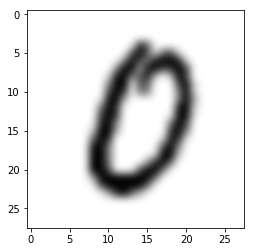

In [6]:
def plot_mnist_digit(digit):
    image = digit.reshape(28, 28)
    plt.imshow(image, cmap='binary', interpolation='bicubic')

#choose a random number, plot it and check label 
random_number = np.random.randint(1,60001)
print('label:',y[random_number]) 
plot_mnist_digit(X[random_number])

After a glimpse into MNIST let us explore it a bit further. Write a function ``` plot_mnist_digits(data, examples_each_row)``` that plots configurable number of examples for each class, like:
![MNIST Examples](images/MNIST_matrix.png)

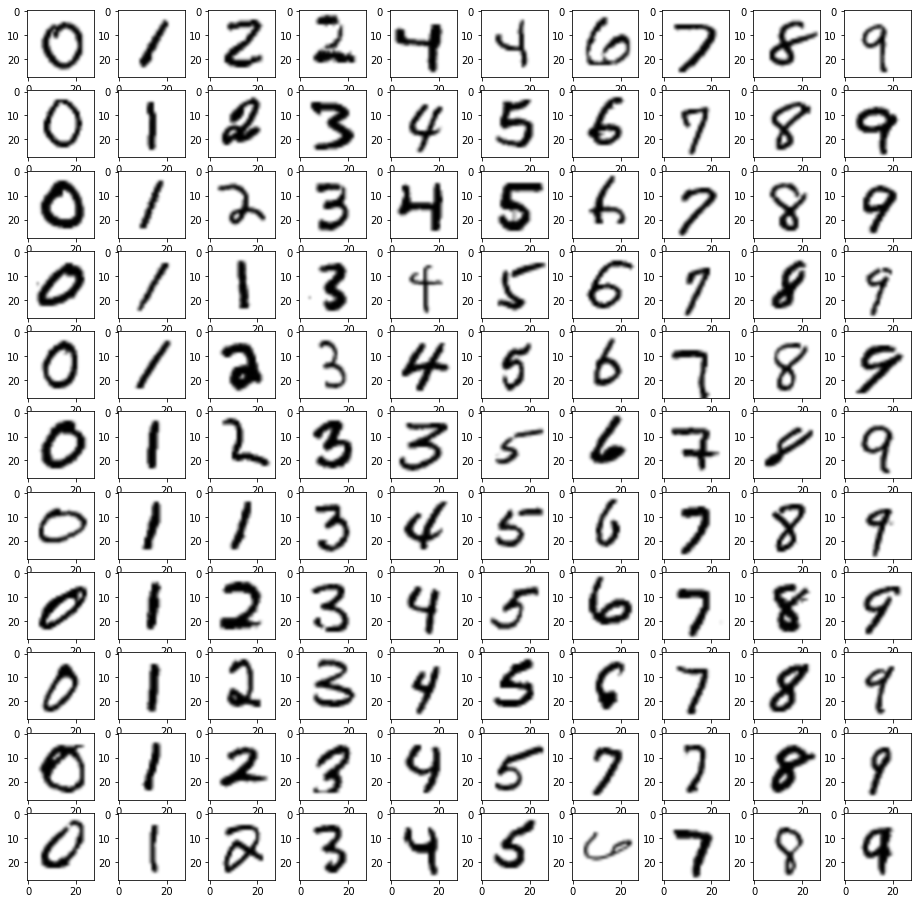

In [7]:
## die daten sind so geformt das die ersten 1000 0 sind und die dann 1 und so weiter 


def plot_mnist_digits(data, examples_each_row):
    ############################################
    #TODO: Write a function that plots as many #    
    #      examples of each class as defiend   #
    #      by 'examples_each_row'              #
    ############################################
    data = data[:60000]
    plt.figure(figsize=(16,16))
    data = data.reshape(10,-1, 784)
    
    for o in range(examples_each_row):
        for i in range(10):
            plt.subplot(examples_each_row, 10, o * 10 + i + 1  )
            digit = data[(o * 10 + i ) %10][np.random.randint(1 ,6001)]
            
            image = digit.reshape(28, 28)
            plt.imshow(image, cmap='binary', interpolation='bicubic')

    ############################################
    #             END OF YOUR CODE             #
    ############################################
    
plot_mnist_digits(X, examples_each_row=11)
plt.show() 

After exploring MNIST let us prepare the date for our linear classifier. First we need to separate traning and test data. Further we will shuffle the traning data to get a random distribution.  

In [8]:
# split data into training and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# shuffle training data
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Define a linear classifier using Softmax

We will train a model to classify the MNIST dataset with the following equation:

$$ L = \frac{1}{M} \sum_{i=1}^{M} -log\; \left ( \frac{e^{h(x_j,\Theta)}}{\sum_{k=1}^{K}e^{h(x_k,\Theta)}} \right)_i + \frac{\lambda}{2} \sum_{}^{} \Theta^2, \: with \;\; h(X,\Theta) = X * \Theta $$

Using the universal equation for a loss function we can see the separate parts of that hugh equation.  

$$ L = \frac{1}{N} \sum_i L_i(h(x_i,\Theta),y_i) + \lambda R(\Theta)$$

We will implement each part on its own and put them together. That way it is much easier to understand whats going on. Let us start with the score function or hypothesis:

$$h(X,\Theta) = X * \Theta$$

It is possible to calculate all score values with one matrix multiplication ([dot product](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.dot.html)) so we can use the whole traning data $X$ instead of one digit $x_i$.

In [9]:
def class_scores(X,theta):
    ############################################
    #TODO: Implement the hypothesis and return #
    #      the score values for each class of  #
    #      every digit.                        #
    ############################################
    return np.dot(X,theta)
    ############################################
    #             END OF YOUR CODE             #
    ############################################


After we can define the data loss funtion $L_i$. We assume the score values are unnormalized log probabilities and we use the softmax function to calculate probabilities.
$$ P(Y=j\mid X=x_i) = \frac{e^{s_j}}{\sum_{k=1}^{K}e^{s_k}} $$
$$ L_i = -log\;P(Y=j\mid X=x_i) $$

Hint: If the correct classes (labels) are in a [one hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) shape you can use a matrix multiplication to extract the correct class. 

In [10]:
# Support function to convert label vector into a one hot encoding matrix
def onehot_encode_label(label):
    onehot_encoder = OneHotEncoder(sparse=False)
    label = label.reshape(len(label), 1)
    onehot_encoded_label = onehot_encoder.fit_transform(label)
    return onehot_encoded_label

# Calculate class probability distribution for each digit from given class scores
def softmax(class_scores):
    ############################################
    #TODO: Use the softmax function to compute #
    #      class probabilties                  #
    ############################################
    exps = np.exp(class_scores)
    return exps / np.sum(exps)
    ############################################
    #             END OF YOUR CODE             #
    ############################################

# Compute data_loss L_i for the correct class
def data_loss(class_probabilities, onehot_encode_label):
    ############################################
    #TODO: With hot encoded labels and class   #
    #      probabilties calculate data loss    #
    #      L_i                                 #
    ############################################
    return - (np.log(class_probabilities) * onehot_encode_label)
    ############################################
    #             END OF YOUR CODE             #
    ############################################
    

Now we will calculate loss $L$ using the defined functions. 

$$ L = \frac{1}{M} \sum_i L_i(h(x_i,\Theta),y_i) + \lambda R(\Theta)$$

Besides the loss L we will have to calculate the gradient for our loss function $L$. To minimize our loss we will need the gradient. For more information about the gradient you can use additional sources, like that good [blog post](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/).

In [11]:
def loss(X, y, theta, lam):
    encoded_labels = onehot_encode_label(y)           # also needed for the gradient, therefore separated calculated
    probabilities = softmax(class_scores(X,theta))    # also needed for the gradient, therefore separated calculated
    loss_Li = data_loss(probabilities,encoded_labels) 
    
    m = X.shape[0]                                    # number of training data for normalization
    l2_regularization = (lam/2)*np.sum(theta*theta)   # regularization loss
  
    ############################################
    #TODO: Put everthing together and calculte #
    #      loss L and gradient dL with given   #
    #      variables.                          #
    ############################################
    loss = 1/m * np.sum(loss_Li ) + l2_regularization
    
    d2l_regulation = lam * theta
    
    abl_loss = 1/m * np.dot(X.T, encoded_labels - probabilities) + d2l_regulation
    gradient= abl_loss  + l2_regularization
    #ableitung der loss funktion
    ############################################
    #             END OF YOUR CODE             #
    ############################################
    
    return loss,gradient

## Reduce the cost using gradient descent

In [12]:
def gradient_descent(traning_data, traning_label, theta, lam=0.5, iterations=100, learning_rate=1e-5):
    losses = []
    ############################################
    #TODO: Optimize loss with gradient descent #
    #      update rule. Return a final model   #
    #      and a history of loss values.       #
    ############################################
    for i in range(0,iterations):
        L, grad = loss(traning_data,traning_label, theta,lam)
        theta += learning_rate * grad
        losses.append(L)
    ############################################
    #             END OF YOUR CODE             #
    ############################################    
    return theta, losses

# Initialize learnable parameters theta 
theta = np.zeros([X_train.shape[1],len(np.unique(y_train))])
# Start optimization with traning data, theta and optional hyperparameters
opt_model, loss_history = gradient_descent(X_train,y_train,theta,iterations=10)

## Evaluate model
Let us look at the optimization results. Final loss tells us how far we could reduce costs during traning process. Further we can use the first loss value as a sanity check and validate our implementation of the loss function works as intended. Recall loss value after first iteration should be $ log\:c$ with $c$ being number of classes. To visulize the whole tranings process we can plot losss values from each iteration as a loss curve. 

last iteration loss: 44.112804808265295
first iteration loss: 13.304684934198287


Text(0.5,0,'iterations')

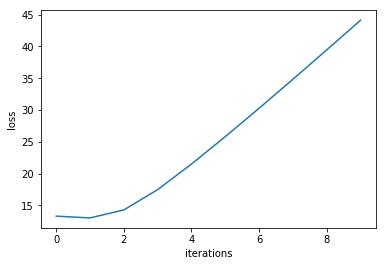

In [13]:
# check loss after last iteration
print('last iteration loss:',loss_history[-1])
# Sanity check: first loss should be ln(10)
print('first iteration loss:',loss_history[0])
# Plot a loss curve
plt.plot(loss_history)
plt.ylabel('loss')
plt.xlabel('iterations')

Evaluation above gave us some inside about the optimization process but did not quantified our final model. One possibility is to calculate model accuracy.

In [14]:
def modelAccuracy(X,y,theta):
    # calculate probabilities for each digit
    probabilities = softmax(np.dot(X,theta))
    # class with highest probability will be predicted
    prediction = np.argmax(probabilities,axis=1)
    # Sum all correct predictions and divied by number of data
    accuracy = (sum(prediction == y))/X.shape[0]
    return accuracy

print('Training accuracy: ', modelAccuracy(X_train,y_train,opt_model))
print('Test accuracy: ', modelAccuracy(X_test,y_test,opt_model))

Training accuracy:  0.6719
Test accuracy:  0.6805


But that quantification is limited. A more gerenell approach is to calculate a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) and get different model measurements from it. A good overview for model measurements is provided by the wikipedia article of [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). We implement a confusion matrix for our model and calculate a [F1 score](https://en.wikipedia.org/wiki/F1_score) and ```print()``` it.

In [15]:
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN += 1

    return(TP, FP, TN, FN)


In [16]:
def confusionMatrix(X,y,theta):
    ############################################
    #TODO: Calculate a confusion matrix for    # 
    #      and it.                             #
    ############################################
    # calculate probabilities for each digit
    probabilities = softmax(np.dot(X,theta))
    # class with highest probability will be predicted
    prediction = np.argmax(probabilities,axis=1)
    # Sum all correct predictions and divied by number of data
    TP,FP,FN,TN = perf_measure(y, prediction)
    cm = [[TP, FP],[FN, TN]]
    print (cm)
    return cm
    ############################################
    #             END OF YOUR CODE             #
    ############################################
    
def f1Score(confMatrix):
    ############################################
    #TODO: Calculate a F1 score from a given   #
    #      confusion matrix.                   #
    ############################################
  
    return (2*cm[0][0]) / (2* cm[0][0] + cm[0][1] + cm[1][0])
    ############################################
    #             END OF YOUR CODE             #
    ############################################ 
   
                           
cm = confusionMatrix(X_train,y_train,theta)
print("F1 Score :" ,f1Score(cm))
    ### extra sachen machen 



[[5093, 156], [5787, 6697]]
F1 Score : 0.6315332630665261


In [17]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()
def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows
def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

print("label precision recall")
for y in range(10):
    print(f"{y:5d} {precision(y, cm):9.3f} {recall(y, cm):6.3f}")

SyntaxError: invalid syntax (<ipython-input-17-007cdc938aee>, line 23)

Interesting is to plot a part of $theta$, because you can visualize the learned templates for each class.

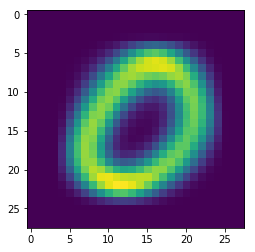

In [18]:
plt.imshow(np.reshape(opt_model[:,0],[28,28]))